In [ ]:
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from pandas import date_range

import pycompo.core.filter as pcfilter
import pycompo.core.utils as pcutil

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc03.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='3H',
        )
    ]

feature_var = config['data']['feature_var']

### Read in feature_data

In [ ]:
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

basic_outpath = config['data']['outpath']
inpath_featprops = Path(f"{basic_outpath}/{analysis_idf}/feature_props/")
inpath_featcompo = Path(f"{basic_outpath}/{analysis_idf}/feature_compo_data/")

features = []
global_feature_id = 1
for time in analysis_times[:-1]:
    file_timestr = pcutil.np_datetime2file_datestr(time)
    
    infile_featcompo = inpath_featcompo/\
        Path(f"{analysis_idf}_feature_compo_data_{file_timestr}.nc")
    feature_compo_data = xr.open_dataset(infile_featcompo).compute()
    
    infile_featprops = inpath_featprops/\
        Path(f"{analysis_idf}_feature_props_{file_timestr}.nc")
    feature_props = xr.open_dataset(infile_featprops)
    feature_props = feature_props[
        ['time', 'area_km2', 'centroid_idx', f'{feature_var}_ano_mean',]
        ].compute()
    
    feature_props = feature_props.where(
        feature_props['feature_id'].isin(feature_compo_data['feature_id']),
        drop=True,
    )
    feature = xr.merge([feature_props, feature_compo_data])

    global_feature_id_old = global_feature_id
    global_feature_id = global_feature_id + feature.sizes['feature']
    feature['feature_id'] = (
        'feature', range(global_feature_id_old, global_feature_id)
        )
    features.append(feature)
features = xr.concat(features, dim='feature')

# save feature composite data
outpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(f"{analysis_idf}_feature_compo_data_full.nc")
feature_compo_data.attrs["identifier"] = analysis_idf
#feature_compo_data.to_netcdf(str(outpath/outfile))

In [ ]:
features = xr.concat(features, dim='feature')

# save feature composite data
outpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(f"{analysis_idf}_feature_compo_data_full.nc")
feature_compo_data.attrs["identifier"] = analysis_idf

In [ ]:
# ----------------------------------------------------------------------
# create a single feature composite file
# --------------------------------------
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/features/")

features = []
global_feature_id = 1
for time in analysis_times[:-1]:
    # read in data
    file_timestr = pcutil.np_datetime2file_datestr(time)
    infile = inpath/Path(f"{analysis_idf}_features_{file_timestr}.nc")
    feature = xr.open_dataset(infile).compute()
    
    # set global feature id
    global_feature_id_old = global_feature_id
    global_feature_id = global_feature_id + feature.sizes['feature']
    global_feature_ids = range(global_feature_id_old, global_feature_id)
    feature['feature_id'] = ('feature', global_feature_ids)
    features.append(feature)

features = xr.concat(features, dim='feature')
features.attrs["identifier"] = analysis_idf

# save feature composite data
outpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(f"{analysis_idf}_features_all.nc")
features.to_netcdf(str(outpath/outfile))

### Build precipitation climatology for subsampling

In [ ]:
# read in data
def roll_avg(
        dset: xr.DataArray | xr.Dataset,
        clim_avg_days: int | float,
        spd: int,
        ) -> xr.DataArray | xr.Dataset:
    window_size = int(clim_avg_days*spd + 1)
    rolling_avg = dset.rolling(time=window_size, center=True).mean()
    return rolling_avg


inpath = Path(config['data']['inpaths']['pr'])
in_pattern = f"{config['exp']}_tropical_pr_*.nc"
infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
pr_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()['pr']

# detrend dataset with multiyear monthly climatology
if 1 == 2:
    pr_clim = pcfilter.build_hourly_climatology(
        pr_clim, clim_baseyear=str(config['detrend']['clim_baseyear'])
        )
    pr_clim = pcutil.circ_roll_avg(
        pr_clim, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
else:
    pr_clim = roll_avg(
        pr_clim, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
    pr_clim = pr_clim.sel(time=slice(analysis_times[0], analysis_times[-1]))

pr_clim = pr_clim.persist()
pr_q80 = pr_clim.quantile(0.8, dim=['lat', 'lon'])
pr_clim = pr_clim.sel(lat=slice(*config['lat_range']), drop=True).compute()
rainbelt = xr.where(pr_clim >= pr_q80, True, False).compute()

### Subsampling

In [ ]:
# Geographic subsampling
keep_idx = []
for idx, _ in enumerate(features):
    feature = features.isel(feature=idx)
    if rainbelt.sel(time=feature['time']).isel(
        lat=int(feature['centroid_idx'].sel(component='lat')),
        lon=int(feature['centroid_idx'].sel(component='lon')),
        ).values:
        keep_idx.append(int(feature['feature_id'].values))
features_sampled = features.where(
    features['feature_id'].isin(keep_idx), drop=True,
    )

<xarray.Dataset>
Dimensions:                (feature: 7, component: 2, x: 51, y: 51)
Coordinates:
    feature_id             (feature) int64 1 2 5 6 9 12 14
  * component              (component) object 'lat' 'lon'
    En_rota2_featcen_x     (x) float64 -2.5 -2.4 -2.3 -2.2 ... 2.2 2.3 2.4 2.5
    En_rota2_featcen_y     (y) float64 -2.5 -2.4 -2.3 -2.2 ... 2.2 2.3 2.4 2.5
Dimensions without coordinates: feature, x, y
Data variables: (12/17)
    time                   (feature) datetime64[ns] 2020-03-01 ... 2020-03-01
    area_km2               (feature) float64 466.5 1.12e+03 ... 938.9 845.9
    centroid_idx           (feature, component) float64 7.2 153.4 ... 2.925e+03
    ts_ano_mean            (feature) float64 0.2464 0.2283 ... 0.223 0.2269
    ts_ano                 (feature, x, y) float64 -0.01436 -0.005048 ... 0.2059
    ts_ano_laplacian       (feature, x, y) float64 2.108e-10 ... 2.356e-10
    ...                     ...
    hfss_ano               (feature, x, y) float64 -3.047 -2.435 ... 1.038 1.036
    rlut_ano               (feature, x, y) float64 -32.25 -27.62 ... 24.04 23.57
    cllvi_ano              (feature, x, y) float64 0.04189 0.0292 ... -0.05363
    clivi_ano              (feature, x, y) float64 0.04823 0.03687 ... -0.003449
    sfcwind_ano            (feature, x, y) float64 0.2534 0.2265 ... -0.4302
    ps_ano                 (feature, x, y) float64 6.173 5.285 ... -6.32 -6.548
Attributes:
    identifier:  ngc5004_pc02

In [86]:
features_composite = features.mean(dim='feature')

### Visualization of composites

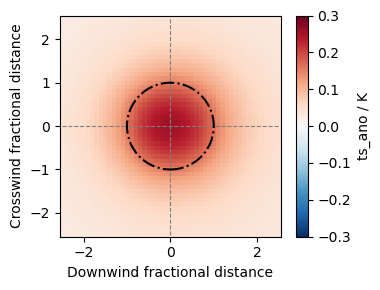

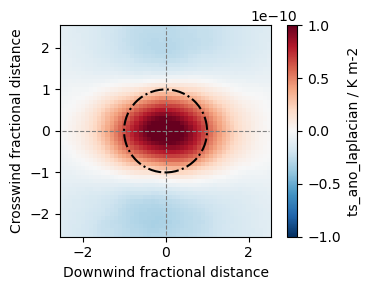

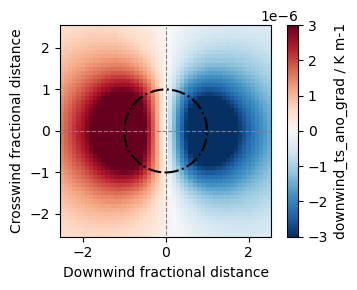

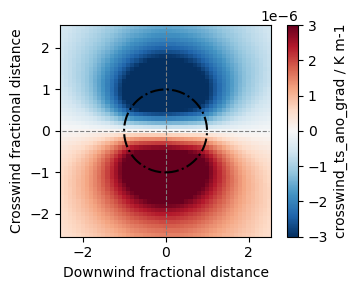

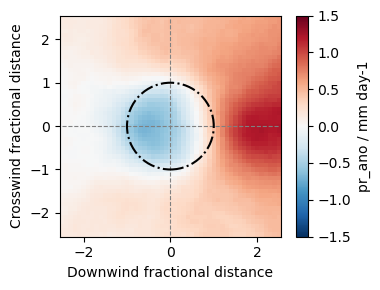

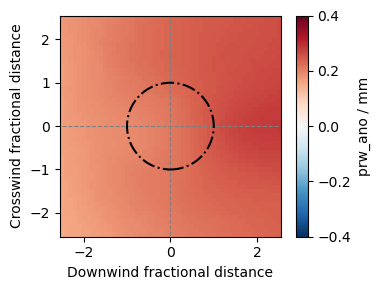

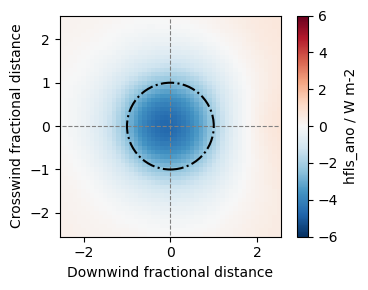

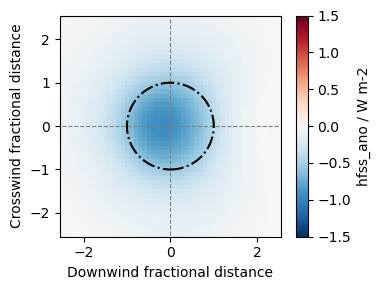

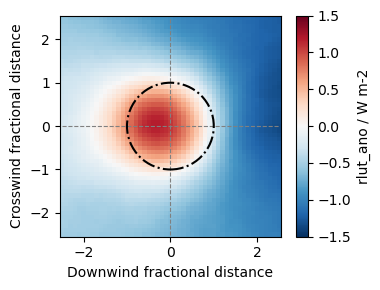

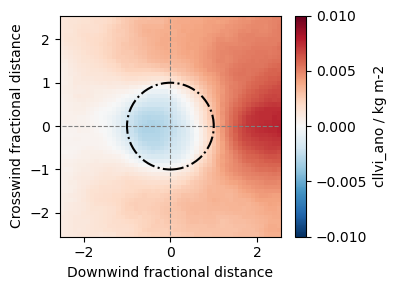

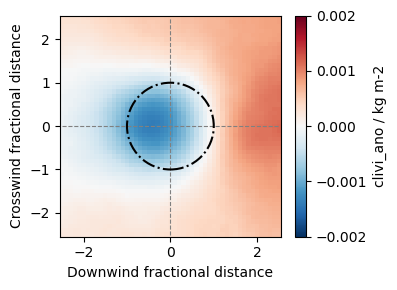

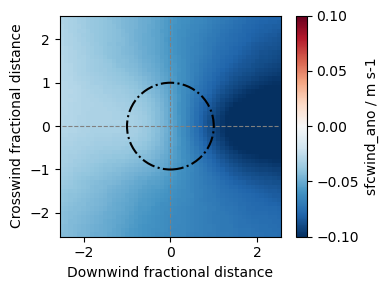

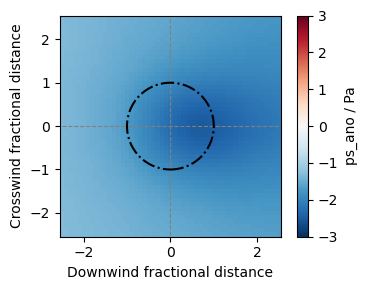

In [99]:
import pycompo.core.plot as pcplot
import importlib as implib
implib.reload(pcplot)

for var in feature_compo_data.data_vars:
    pcplot.plot_composite(features_composite[var])

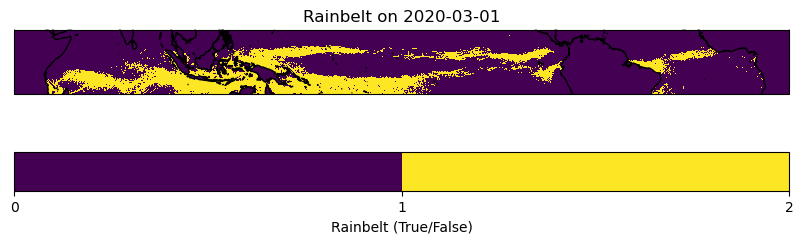

In [48]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
rainbelt.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    levels=[0, 1, 2],
    cbar_kwargs={'label': 'Rainbelt (True/False)', 'orientation': 'horizontal'}
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()

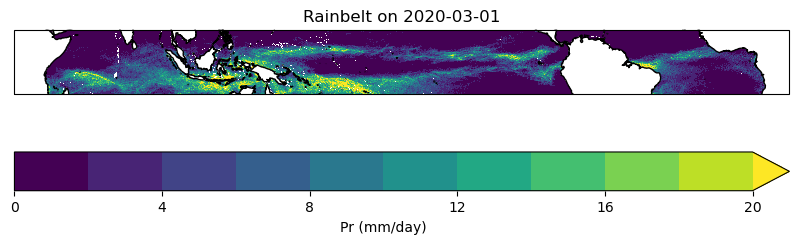

In [46]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
pr_clim.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(), 
    cbar_kwargs={'label': 'Pr (mm/day)', 'orientation': 'horizontal'},
    levels=np.arange(0,21,2)
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()

## SANDBOX

### Read in SST clusters and cutout of corresponding data

In [ ]:
from pandas import date_range

analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='3H',
        )
    ]
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

basic_outpath = config['data']['outpath']
inpath_featprops = Path(f"{basic_outpath}/{analysis_idf}/feature_props/")
inpath_featcompo = Path(f"{basic_outpath}/{analysis_idf}/feature_compo_data/")

infiles_featprops = []
infiles_featcompo = []

for time in analysis_times[:1]:
    file_timestr = pcutil.np_datetime2file_datestr(time)
    infiles_featprops.append(
        inpath_featprops/\
            Path(f"{analysis_idf}_feature_props_{file_timestr}.nc")
        )
    infiles_featcompo.append(
        inpath_featcompo/\
            Path(f"{analysis_idf}_feature_compo_data_{file_timestr}.nc")
        )
feature_compo_data = xr.open_mfdataset(
    infiles_featcompo, combine='nested', concat_dim='feature',
    ).compute()
feature_props = xr.open_mfdataset(
    infiles_featprops, combine='nested', concat_dim='feature',
    )[['time', 'area_km2', 'centroid_idx', f'{feature_var}_ano_mean']].compute()
#feature_props['feature_id'] = range(1, feature_props.sizes['feature']+1)